In [15]:
from os import listdir
import numpy as np
from numpy import zeros
from numpy import asarray
from numpy import mean
from numpy import expand_dims
import json
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

from mrcnn.utils import Dataset
from mrcnn.visualize import display_instances
from mrcnn.utils import extract_bboxes
from mrcnn.config import Config
from mrcnn.model import MaskRCNN
from mrcnn.model import load_image_gt
from mrcnn.model import mold_image
from mrcnn.utils import compute_ap

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [ ]:
%cd Mask_RCNN

In [ ]:
!python setup.py install

In [ ]:
!pip install -r requirements.txt

In [ ]:
%cd ..

In [16]:
# split into train and test set


# class that defines and loads the maximum-speed-limit dataset
class MaximumSpeedLimitDataset(Dataset):
	# load the dataset definitions
  def load_dataset(self, dataset_dir, train_part=0.8, is_train=True):
    # define one class
    self.add_class("dataset", 1, "maximumspeedlimit")
    # define data locations
    main_dir = 'maximum-speed-limit/'


    matching = [s for s in listdir(main_dir) if "jpg" in s]
    samples = np.random.choice(matching, 300, replace=False)
    train_num = int(300 * train_part)

    if is_train:
      images_set = samples[:train_num]#matching[:1600]
    else:
      images_set = samples[train_num:]#matching[1600:]



    # find all images
    for filename in images_set:
      # extract image id
      image_id = filename[:-3]

      img_path = main_dir + filename
      ann_path = main_dir + filename[:-3] + 'json'
      # add to dataset
      self.add_image('dataset', image_id=image_id, path=img_path, annotation=ann_path)



  # function to extract bounding boxes from an annotation file
  def extract_boxes(self, filename):
    with open(filename) as file:
      config_str = file.read()

    json_config = json.loads(config_str)
    # extract each bounding box
    boxes = list()
    for _ in json_config:
      xmin = int(_['bbox']['xmin'])
      ymin = int(_['bbox']['ymin'])
      xmax = int(_['bbox']['xmax'])
      ymax = int(_['bbox']['ymax'])
      coors = [xmin, ymin, xmax, ymax]
      boxes.append(coors)

    im = Image.open(filename[:-4] + 'jpg')
    width, height = im.size
    return boxes, width, height


	# load the masks for an image
  def load_mask(self, image_id):
    # get details of image
    info = self.image_info[image_id]
    # define box file location
    path = info['annotation']
    # load XML
    boxes, w, h = self.extract_boxes(path)
    # create one array for all masks, each on a different channel
    masks = zeros([h, w, len(boxes)], dtype='uint8')
    # create masks
    class_ids = list()
    for i in range(len(boxes)):
      box = boxes[i]
      row_s, row_e = box[1], box[3]
      col_s, col_e = box[0], box[2]
      masks[row_s:row_e, col_s:col_e, i] = 1
      class_ids.append(self.class_names.index('maximumspeedlimit'))
    return masks, asarray(class_ids, dtype='int32')

	# load an image reference
  def image_reference(self, image_id):
    info = self.image_info[image_id]
    return info['path']

# train set
train_set = MaximumSpeedLimitDataset()
train_set.load_dataset('maximumspeedlimit', is_train=True)
train_set.prepare()
print('Train: %d' % len(train_set.image_ids))

# test/val set
test_set = MaximumSpeedLimitDataset()

test_set.load_dataset('maximumspeedlimit', is_train=False)
test_set.prepare()
print('Test: %d' % len(test_set.image_ids))

Train: 240
Test: 60


(3024, 4032, 3)
(3024, 4032, 1)


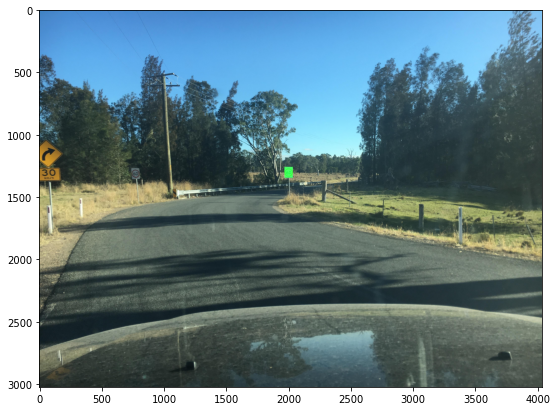

In [17]:
# load an image
image_id = 8
image = train_set.load_image(image_id)
print(image.shape)
# load image mask
mask, class_ids = train_set.load_mask(image_id)
print(mask.shape)
# plot image
plt.figure(figsize=(9, 9))
image[mask[:, :, 0] > 0, 1] = 255
plt.imshow(image)
# plot mask
plt.show()


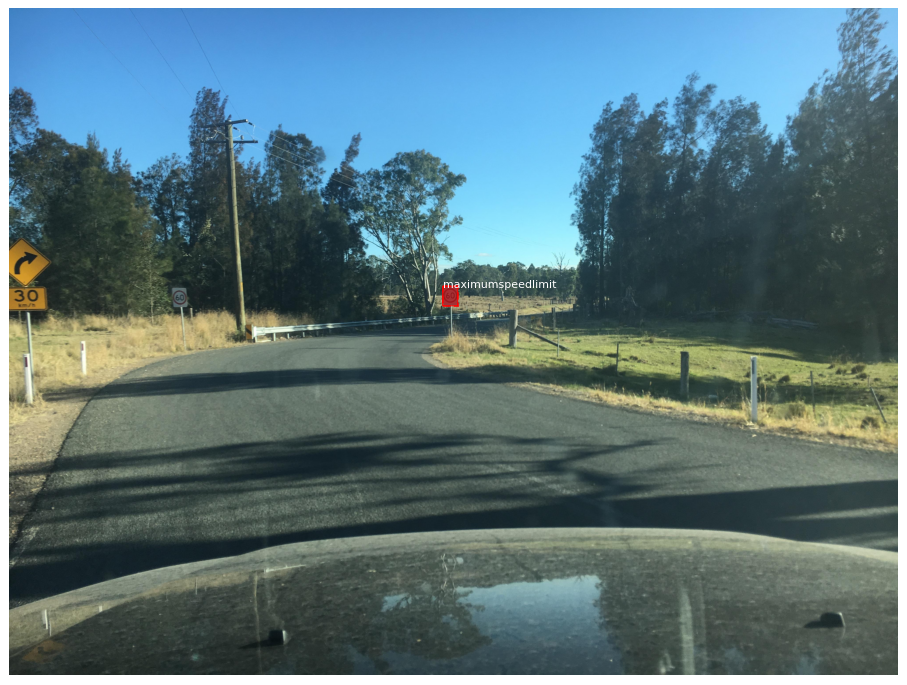

In [18]:
# define image id
image_id = 8
# load the image
image = train_set.load_image(image_id)
# load the masks and the class ids
mask, class_ids = train_set.load_mask(image_id)
# extract bounding boxes from the masks
bbox = extract_bboxes(mask)
# display image with masks and bounding boxes
display_instances(image, bbox, mask, class_ids, train_set.class_names)

In [10]:

# define a configuration for the model
class MaximumSpeedLimitConfig(Config):
	# define the name of the configuration
	NAME = "maximumspeedlimit_cfg"
	# number of classes (background + maximumspeedlimit)
	NUM_CLASSES = 1 + 1
	# number of training steps per epoch
	STEPS_PER_EPOCH = 50

config = MaximumSpeedLimitConfig()


In [18]:
model = MaskRCNN(mode='training', model_dir='road_signs/', config=config)

In [19]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

model.load_weights('mask_rcnn_coco.h5', by_name=True, exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",  "mrcnn_bbox", "mrcnn_mask"])

model.train(train_set, test_set, learning_rate=config.LEARNING_RATE, epochs=2, layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: road_signs/maximumspeedlimit_cfg20210103T1957\mask_rcnn_maximumspeedlimit_cfg_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistribut

In [19]:
# define the prediction configuration
class PredictionConfig(Config):
    # define the name of the configuration
    NAME = "maximumspeedlimit_cfg"
    IMAGES_PER_GPU = 1
    # number of classes (background + kangaroo)
    NUM_CLASSES = 1 + 1



cfg = PredictionConfig()


In [20]:
model = MaskRCNN(mode='inference', model_dir='road_signs/', config=cfg)

# load model weights
model.load_weights('road_signs\maximumspeedlimit_cfg20210103T1914\mask_rcnn_maximumspeedlimit_cfg_0005.h5', by_name=True)

Re-starting from epoch 5


In [23]:
def evaluate_model(dataset, model, cfg):
    APs = list()
    num = len(dataset.image_ids)
    for i, image_id in enumerate(dataset.image_ids):
        # load image, bounding boxes and masks for the image id
        image, image_meta, gt_class_id, gt_bbox, gt_mask = load_image_gt(dataset, cfg, image_id, use_mini_mask=False)
        # convert pixel values (e.g. center)
        scaled_image = mold_image(image, cfg)
        # convert image into one sample
        sample = expand_dims(scaled_image, 0)
        # make prediction
        yhat = model.detect(sample, verbose=0)
        # extract results for first sample
        r = yhat[0]
        # calculate statistics, including AP
        AP, _, _, _ = compute_ap(gt_bbox, gt_class_id, gt_mask, r["rois"], r["class_ids"], r["scores"], r['masks'])
        # store
        APs.append(AP)
        print(f'{i} / {num}', end='\r')
    # calculate the mean AP across all images
    mAP = mean(APs)
    print()
    return mAP

In [ ]:
# evaluate model on training dataset
train_mAP = evaluate_model(train_set, model, cfg)
print("Train mAP: %.3f" % train_mAP)
# evaluate model on test dataset
test_mAP = evaluate_model(test_set, model, cfg)
print("Test mAP: %.3f" % test_mAP)

In [ ]:
# plot a number of photos with ground truth and predictions
def plot_actual_vs_predicted(dataset, model, cfg, n_images=5):
    # load image and mask
    for i in range(n_images):
        # load the image and mask
        image = dataset.load_image(i)
        mask, _ = dataset.load_mask(i)
        # convert pixel values (e.g. center)
        scaled_image = mold_image(image, cfg)
        # convert image into one sample
        sample = expand_dims(scaled_image, 0)
        # make prediction
        yhat = model.detect(sample, verbose=0)[0]
        # define subplot
        plt.figure(figsize=(18, 18))
        # plot raw pixel data
        for j in range(mask.shape[2]):
            image[mask[:, :, 0] > 0, 1] = 255
        # get the context for drawing boxes
        plt.imshow(image)
        ax = plt.gca()
        # plot each box
        for box in yhat['rois']:
            # get coordinates
            y1, x1, y2, x2 = box
            # calculate width and height of the box
            width, height = x2 - x1, y2 - y1
            # create the shape
            rect = Rectangle((x1, y1), width, height, fill=False, color='red')
            # draw the box
            ax.add_patch(rect)
        # show the figure
        plt.show()


plot_actual_vs_predicted(train_set, model, cfg)
# plot predictions for test dataset
plot_actual_vs_predicted(test_set, model, cfg)